## cdef class callback vs cython ode vs python ode

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from probDE.utils.utils import rand_mat
from scipy.integrate import odeint
%load_ext cython

In [ ]:
%%cython
from libc.math cimport sin
import numpy as np
cimport numpy as np

DTYPE = np.double
ctypedef np.double_t DTYPE_t

cdef class fun:
    cpdef np.ndarray[DTYPE_t, ndim=1] ode_fun(self, double[::1] x_t, double t, theta=None):
        return np.array([0])

cdef class odefun(fun):
    cpdef np.ndarray[DTYPE_t, ndim=1] odefun(self, double[::1] x_t, double t, theta=None):
        return np.array([sin(2*t) - x_t[0]])

In [ ]:
from math import sin
def ode_py(x_t, t, theta=None):
    return np.array([sin(2*t) - x_t[0]])

In [ ]:
%%cython
from libc.math cimport sin
import numpy as np
cimport numpy as np

DTYPE = np.double
ctypedef np.double_t DTYPE_t

cpdef np.ndarray[DTYPE_t, ndim=1] ode_cp(double[::1] x_t, double t, theta=None):
    return np.array([sin(2*t) - x_t[0]])

In [ ]:
x0_state = np.random.rand(4)
f = odefun()

In [ ]:
%timeit -o -n 100000 ode_py(x0_state, 0)

In [ ]:
%timeit -o -n 100000 ode_cp(x0_state, 0)

In [ ]:
%timeit -o -n 100000 f.odefun(x0_state, 0)

## KalmanODE & KalmanODE_py

In [2]:
from KalmanTest.KalmanODE_py import KalmanODE_py
from probDE.cython.KalmanTest.KalmanODE import KalmanODE

In [ ]:
# These parameters define the order of the ODE and the CAR(p) process
n_meas = 1
n_state = 3

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_steps = 50
n_eval = n_steps-1
tmin = 0
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = 50
sigma = .001

# Initial value, a, for the IVP
w = np.array([0., 0., 1.])
x0 = np.array([-1., 0., 1.]) #Initial State
z_states = rand_mat(2*n_steps, n_state) #Random matrix

# Run the solver to get an approximation
kalmanode_py = KalmanODE_py(n_state, n_meas, tmin, tmax, n_eval, ode_py) # Initialize the class
x0_state = kalmanode_py.initialize(w, tau, sigma, x0) # Get the initial x0_state using initialize method
kalmanode_py.z_states = z_states # Set class z_states property as random matrix defined (can be omitted)
kalman_py_sim, kalman_py_mu, kalman_py_var = kalmanode_py.solve(x0_state, mv=True, sim=True) # Run the solver

In [ ]:
kalmanode = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, ode_py) # Initialize the class
x0_state = kalmanode.initialize(w, tau, sigma, x0) # Get the initial x0_state using initialize method
kalmanode.z_states = z_states # Set class z_states property as random matrix defined (can be omitted)
kalman_sim, kalman_mu, kalman_var = kalmanode.solve(x0_state, mv=True, sim=True)

In [ ]:
tseq = np.linspace(tmin, tmax, n_steps)
plt.plot(tseq, kalman_py_sim[:, 1], label = 'Python mean')
plt.plot(tseq, kalman_sim[:, 1], label = 'C mean')
plt.legend(loc='upper left')

In [ ]:
kalman_cy = %timeit -o -n 100 _, _, _ = kalmanode.solve(x0_state, mv=True, sim=True)

In [ ]:
kalman_py = %timeit -o -n 100 _, _, _ = kalmanode_py.solve(x0_state, mv=True, sim=True)

In [ ]:
kalman_py.average/kalman_cy.average

## Lorenz63

In [ ]:
def lorenz0(state, t):
    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    x, y, z = state  # Unpack the state vector
    return -sigma*x + sigma*y, rho*x - y -x*z, -beta*z + x*y

In [ ]:
# RHS of ODE
def lorenz(X_t, t, theta=None):
    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    p = 3
    x, y, z = X_t[p*0], X_t[p*1], X_t[p*2]
    return np.array([-sigma*x + sigma*y, rho*x - y -x*z, -beta*z + x*y]) 

# LHS Matrix of ODE
w_mat = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]])

# These parameters define the order of the ODE and the CAR(p) process
n_var = 3 # Number of variates
n_meas = 1 # ODE order
n_state = 3 # number of continuous derivatives of CAR(p) solution prior

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_steps = 5000 
n_eval = n_steps -1
tmin = 0
tmax = 20

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = 1
sigma = .001
sigmalst = [sigma]*n_var
scale = 10 # Scaling factor for root generation

# Initial value, a, for the IVP
x0 = [-12, -5, 38]
v0 = lorenz0(x0, 0)
a = np.array(list(zip(x0, v0)), dtype=np.double)
z_states = rand_mat(2*n_steps, n_var*n_state)

# Run the solver to get an approximation
kalmanode_py = KalmanODE_py(n_state, n_meas, tmin, tmax, n_eval, lorenz) # Initialize the class
x0_state = kalmanode_py.multi_initialize(w_mat, tau, sigmalst, a, scale) # Get the initial x0_state using initialize method
kalmanode_py.z_states = z_states # Set class z_states property as random matrix defined (can be omitted)
kalman_py_lor_sim, kalman_py_lor_mu, kalman_py_lor_var = kalmanode_py.solve(x0_state, mv=True, sim=True) # Run the solver

In [ ]:
kalmanode = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, lorenz) # Initialize the class
x0_state = kalmanode.multi_initialize(w_mat, tau, sigmalst, a, scale) # Get the initial x0_state using initialize method
kalmanode.z_states = z_states # Set class z_states property as random matrix defined (can be omitted)
kalman_lor_sim, kalman_lor_mu, kalman_lor_var = kalmanode.solve(x0_state, mv=True, sim=True)

In [ ]:
tseq = np.linspace(tmin, tmax, n_steps)
_, axs = plt.subplots(n_var, 1, figsize=(20, 7))
ylabel = ['x', 'y', 'z']
for i in range(n_var):
    axs[i].plot(tseq, kalman_py_lor_sim[:, n_state*i], label="Python")
    axs[i].plot(tseq, kalman_lor_sim[:, n_state*i], label="C")
    axs[i].set_ylabel(ylabel[i])
    axs[i].legend(loc='upper left')

In [ ]:
kalman_lor_cy = %timeit -o _ = kalmanode.solve(x0_state, mv=True, sim=True)

In [ ]:
kalman_lor_py = %timeit -o _, _, _ = kalmanode_py.solve(x0_state, mv=True, sim=True)

In [ ]:
kalman_lor_py.average/kalman_lor_cy.average

## Lane-Emden

In [ ]:
from scipy.integrate import odeint
def lane0(x_t, t):
    return [x_t[1], -2/t*x_t[1] - x_t[0]]

In [ ]:
def lane(x_t, t, theta=None):
    return np.array([-2/t*x_t[1] - x_t[0]])

# These parameters define the order of the ODE and the CAR(p) process
n_meas = 1
n_state = 3

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_steps = 500
n_eval = n_steps-1 
tmin = 1
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = 50
sigma = .001

# Initial value, a, for the IVP
w = np.array([0., 0., 1.])
x0 = np.array([1., 0., -1.]) #Initial State
z_states = rand_mat(2*n_steps, n_state) #Random matrix

# Run the solver to get an approximation
kalmanode_py = KalmanODE_py(n_state, n_meas, tmin, tmax, n_eval, lane) # Initialize the class
x0_state = kalmanode_py.initialize(w, tau, sigma, x0) # Get the initial x0_state using initialize method
kalmanode_py.z_states = z_states # Set class z_states property as random matrix defined (can be omitted)
kalman_py_lane_sim, kalman_py_lane_mu, kalman_py_lane_var = kalmanode_py.solve(x0_state, mv=True, sim=True) # Run the solver

In [ ]:
kalmanode = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, lane) # Initialize the class
x0_state = kalmanode.initialize(w, tau, sigma, x0) # Get the initial x0_state using initialize method
kalmanode.z_states = z_states # Set class z_states property as random matrix defined (can be omitted)
kalman_lane_sim, kalman_lane_mu, kalman_lane_var = kalmanode.solve(x0_state, mv=True, sim=True)

In [ ]:
tseq = np.linspace(tmin, tmax, n_steps)
lane_odeint = odeint(lane0, [1, 0], tseq)
plt.plot(tseq, kalman_py_lane_sim[:, 1], label = 'Python mean')
plt.plot(tseq, kalman_lane_sim[:, 1], label = 'C++ mean')
plt.plot(tseq, lane_odeint[:, 1], label = 'Odeint mean')
plt.legend(loc='upper left')

In [ ]:
kalman_lane_cy = %timeit -o _ = kalmanode.solve(x0_state, mv=True, sim=True)

In [ ]:
kalman_lane_py = %timeit -o _, _, _ = kalmanode_py.solve(x0_state, mv=True, sim=True)

In [ ]:
kalman_lane_py.average/kalman_lane_cy.average

## FitzHugh-Nagumo

In [3]:
def fitz0(X_t, t, theta):
    a, b, c = theta
    V, R = X_t
    return [c*(V - V**3/3 + R), -1/c*(V - a + b*R)]

In [40]:
tmin = 0
tmax = 20
n_steps = 400
theta = [.2, .2, 3]
x0 = [-1, 1]
sigma = 0.1
tseq = np.linspace(tmin, tmax, n_steps)
fitz_ode = odeint(fitz0, x0, tseq, args=(theta,))

In [192]:
# RHS of ODE
def fitz(X_t, t, theta):
    p = 3
    a, b, c = theta
    V, R = X_t[p*0], X_t[p*1]
    return [c*(V - V**3/3 + R), -1/c*(V - a + b*R)]

# LHS Matrix of ODE
w_mat = np.array([[0.0, 1.0], [0.0, 1.0]])

# These parameters define the order of the ODE and the CAR(p) process
n_var = 2 # Number of variates
n_meas = 1 # ODE order
n_state = 3 # number of continuous derivatives of CAR(p) solution prior

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_steps = 400
n_eval = n_steps -1
tmin = 0
tmax = 20
theta = [.2, .2, 3]

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = 100
sigma = .001
sigmalst = [sigma]*n_var

# Initial value, a, for the IVP
x0 = [-1, 1]
v0 = fitz0(x0, 0, theta)
a = np.array(list(zip(x0, v0)), dtype=np.double)
z_states = rand_mat(2*n_steps, n_var*n_state)

In [193]:
# Run the solver to get an approximation
kalmanode_py = KalmanODE_py(n_state, n_meas, tmin, tmax, n_eval, fitz) # Initialize the class
x0_state = kalmanode_py.multi_initialize(w_mat, tau, sigmalst, a) # Get the initial x0_state using initialize method
kalmanode_py.z_states = z_states # Set class z_states property as random matrix defined (can be omitted)
kalman_py_fitz_sim, kalman_py_fitz_mu, kalman_py_fitz_var = kalmanode_py.solve(x0_state, theta=theta, mv=True, sim=True) 

# Run the solver to get an approximation
kalmanode = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, fitz) # Initialize the class
x0_state = kalmanode.multi_initialize(w_mat, tau, sigmalst, a) # Get the initial x0_state using initialize method
kalmanode.z_states = z_states # Set class z_states property as random matrix defined (can be omitted)
kalman_fitz_sim, kalman_fitz_mu, kalman_fitz_var = kalmanode.solve(x0_state, theta=theta, mv=True, sim=True) 

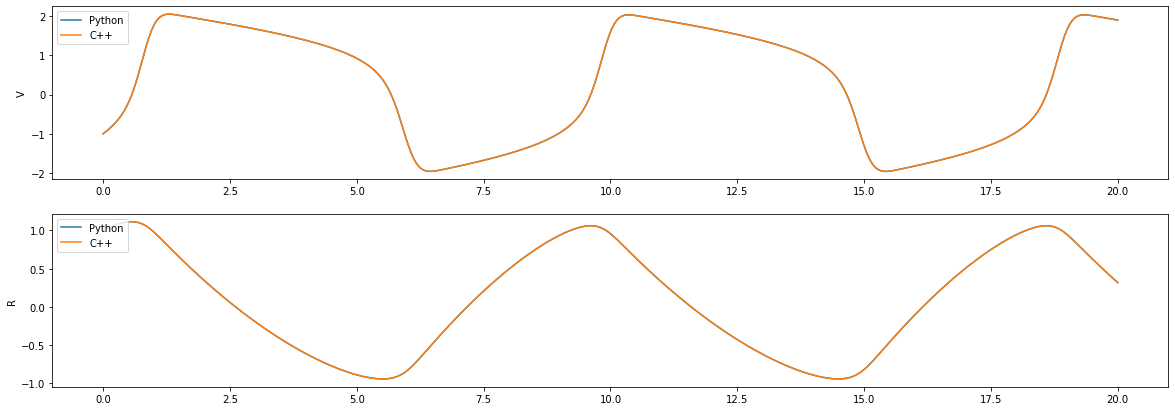

In [194]:
_, axs = plt.subplots(n_var, 1, figsize=(20, 7))
tseq = np.linspace(tmin, tmax, n_steps)
ylabel = ['V', 'R']
for i in range(n_var):
    axs[i].plot(tseq, kalman_py_fitz_sim[:, n_state*i], label="Python")
    axs[i].plot(tseq, kalman_fitz_mu[:, n_state*i], label="C++")
    axs[i].set_ylabel(ylabel[i])
    #axs[i].plot(tseq, fitz_ode[:, i], label='Exact')
    axs[i].legend(loc='upper left')

In [8]:
def normal_loglik(mu, sigma, y):
    n_steps = len(y) 
    loglik =-n_steps/2*(np.log(2*np.pi)- np.sum(np.log(sigma*sigma))) - \
        0.5*np.sum((y - mu)**2/(sigma*sigma))
    return loglik

In [18]:
def fitz_mwg(n_samples, y, theta0, rwsd):
    ntheta = len(theta0)
    theta_curr = theta0
    theta_prop = []
    paccept = np.zeros(ntheta)
    # Parameters for running the solver
    w_mat = np.array([[0.0, 1.0], [0.0, 1.0]])

    # These parameters define the order of the ODE and the CAR(p) process
    n_var = 2 # Number of variates
    n_meas = 1 # ODE order
    n_state = 3 # number of continuous derivatives of CAR(p) solution prior

    # it is assumed that the solution is sought on the interval [tmin, tmax].
    n_steps = 400
    n_eval = n_steps -1
    tmin = 0
    tmax = 20

    # The rest of the parameters can be tuned according to ODE
    # For this problem, we will use
    tau = 100
    sigma = .001
    sigmalst = [sigma]*n_var

    # Initial value, a, for the IVP
    x0 = [-1, 1]
    v0 = fitz0(x0, 0, theta_curr)
    a = np.array(list(zip(x0, v0)), dtype=np.double)
    z_states = rand_mat(2*n_steps, n_var*n_state)
    
    kalmanode = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, fitz) # Initialize the class
    x0_state = kalmanode.multi_initialize(w_mat, tau, sigmalst, a) # Get the initial x0_state using initialize method
    kalmanode.z_states = z_states # Set class z_states property as random matrix defined (can be omitted)
    mu_curr, var_curr = kalmanode.solve(x0_state, theta=theta_curr, mv=True, sim=False)
    lp_curr = normal_loglik(mu_curr[1:, 0], var_curr[1:, 0, 0], y[1:, 0])
    for i in range(n_samples):
        for j in range(ntheta):
            theta_prop = theta_curr[:]
            theta_prop[j] = theta_prop[j] + rwsd[j]*np.random.randn()
            if j!=2 or theta_prop[j]>0:
                v0 = fitz0(x0, 0, theta_prop)
                x0_state[[1, 4]] = v0
                mu_prop, var_prop = kalmanode.solve(x0_state, theta=theta_prop, mv=True, sim=False)
                lp_prop = normal_loglik(mu_prop[1:, 0], var_prop[1:, 0, 0], y[1:, 0])
                lacc = lp_prop - lp_curr     
                if lacc > 0 or np.random.uniform() < np.exp(lacc):
                    theta_curr = theta_prop
                    lp_curr = lp_prop
                    paccept[j] = paccept[j] + 1
    paccept = paccept/n_samples
    return theta_curr, paccept

In [37]:
theta = [0, 0, 1]
rwsd = [.001, .001, .01]
n_samples = 3000

In [41]:
test, paccept = fitz_mwg(n_samples, kalman_fitz_mu, theta, rwsd)
test

In [17]:
n_samples = 3333
kalman_fitz_cy = %timeit -o -n1 -r1 _, _ =  fitz_mwg(n_samples, fitz_ode, theta, rwsd)

34.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [18]:
n_samples = 10000
kalman_fitz_cy2 = %timeit -o -n1 -r1 _, _ =  fitz_mwg(n_samples, fitz_ode, theta, rwsd)

1min 43s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Fitz Contour Plots

In [215]:
n_points = 10
aseq = np.linspace(0, .4, n_points)
bseq = np.linspace(0, .4, n_points)
cseq = np.linspace(2.7, 3.3, n_points)
mcmc_output = np.zeros((n_points, n_points, n_points))
kalmanode = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, fitz)
for i in range(len(aseq)):
    for j in range(len(bseq)):
        for k in range(len(cseq)):
            theta_curr = [aseq[i], bseq[j], cseq[k]]
            v0 = fitz0(x0, 0, theta_curr)
            a = np.array(list(zip(x0, v0)), dtype=np.double)
            x0_state = kalmanode.multi_initialize(w_mat, tau, sigmalst, a)
            mu_curr, var_curr = kalmanode.solve(x0_state, theta=theta_curr, mv=True, sim=False)
            mcmc_output[i, j, k] = normal_loglik(mu_curr[1:, 0], var_curr[1:, 0, 0], kalman_fitz_mu[1:, 0])

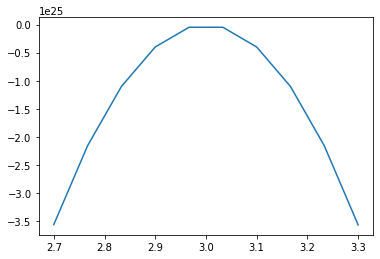

In [220]:
#plt.plot(aseq, np.sum(mcmc_output2, axis=(1,2))*-1/np.sum(mcmc_output2, axis=(0, 1, 2)))
plt.plot(cseq, np.sum(mcmc_output, axis=(0,1)))

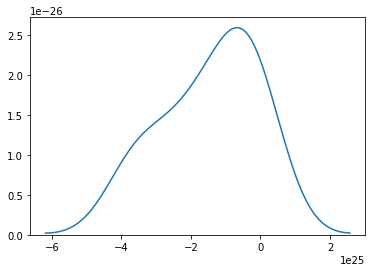

In [222]:
sns.kdeplot(np.sum(mcmc_output, axis=(0,1)))

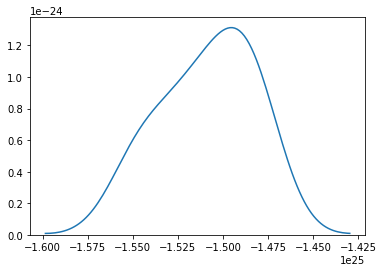

In [214]:
sns.kdeplot(np.sum(mcmc_output, axis=(1,2)))

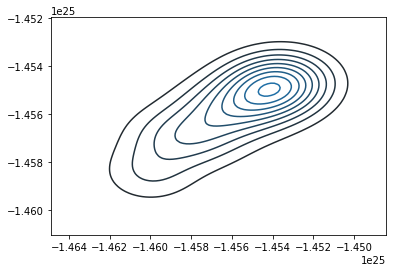

In [250]:
sns.kdeplot(np.sum(mcmc_output, axis=(1,2)), np.sum(mcmc_output, axis=(0,2)))

In [ ]:
plt.contour(aseq, bseq, np.sum(mcmc_output, axis=(2)))